### Home Work 3

In [1]:
pip install gtsam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 19.7 MB/s eta 0:00:00


:THANKS TO PROFESSOR FOR HELPING OUT AND SHARING THE ZHIYONG ZHANG'S CODE.

THE FOLLOWING CODE IS HIGHLY INFLUENCED FROM JORDAN GITTLEMAN

In [2]:
import os
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import scipy.optimize
import math
import gtsam
import gtsam.utils.plot
import itertools

In [3]:
SIFTPoints = namedtuple('SIFTPoints', ['keypoints', 'descriptors'])
#namedtuple is utilized to avoid variations in keypoints and descriptors (since like tuples namedtuples are immutable)

def detect_and_compute_sift(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    sift_detector = cv2.SIFT_create(nfeatures=4000,
                                    nOctaveLayers=8, #I considered 8 octave layers for a better feature detection
                                    contrastThreshold=0.025,
                                    sigma=1.5)

    kp, desc = sift_detector.detectAndCompute(enhanced_image, None)
    return SIFTPoints(kp, desc)

In [4]:
def match_points(d1,d2,pts):

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(d1,d2)
    matches = sorted(matches, key = lambda x:x.distance)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)

    good = []
    goodmatch = 0
    ratio = 0.1
    while goodmatch <= pts:
        for m in matches:
            if m[0].distance < ratio*m[1].distance:
                good.append(m[0])
                goodmatch +=1
        ratio += .1

    good = sorted(good, key = lambda x:x.distance)
    return matches, good

In [5]:
# This is a modified homography function I used for the HW2, using Least Square Method

def compute_homography(dest_kp, src_kp, good):

    A = []
    dest = np.array([dest_kp[mat.queryIdx].pt for mat in good])
    src = np.array([src_kp[mat.trainIdx].pt for mat in good])

    for i in range(len(dest)):
        x_src, y_src = src[i][0], src[i][1]
        x_dest, y_dest = dest[i][0], dest[i][1]

        A.append([-x_src, -y_src, -1, 0, 0, 0, x_src * x_dest, y_src * x_dest, x_dest])
        A.append([0, 0, 0, -x_src, -y_src, -1, x_src * y_dest, y_src * y_dest, y_dest])

    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V.reshape(3, 3)
    #H = H / H[2, 2]

    return H

In [6]:
def compute_homography_with_ransac(dest_kp, src_kp, matches, good_matches):

    dest_points = np.array([dest_kp[match.queryIdx].pt for match in good_matches])
    src_points = np.array([src_kp[match.trainIdx].pt for match in good_matches])

    homography_matrix, inliers_mask = cv2.findHomography(src_points, dest_points, cv2.RANSAC, confidence=0.997) #using cv.homography function

    affine_matrix, _ = cv2.estimateAffinePartial2D(src_points, dest_points)

    scale_factor = math.sqrt(affine_matrix[0, 0]**2 + affine_matrix[0, 1]**2)
    affine_matrix[0, :] /= scale_factor
    affine_matrix[1, :] /= scale_factor

    homography_matrix = np.vstack((affine_matrix, [0, 0, 1]))
    return homography_matrix

In [7]:
def shift_image(image, destination, homography_matrix):

    height1, width1 = image.shape[:2]
    height2, width2 = destination.shape[:2]

    corner_points = [[0, 0], [0, height1], [width1, height1], [width1, 0]]
    transformed_points = []
    for point in corner_points:
        print(np.array([point[0], point[1]]))  # Printing original points
        transformed_point = np.matmul(homography_matrix, np.array([point[0], point[1], 1]))
        transformed_points.append(transformed_point)

    x_min = min(pt[0] / pt[2] for pt in transformed_points)
    x_max = max(pt[0] / pt[2] for pt in transformed_points)

    if x_min < 0:
        x_shift = abs(x_min)
        new_dimensions = (int(x_max + x_shift + width2), height1)
    else:
        x_shift = 0
        new_dimensions = (int(x_max + x_shift + width1), height1)

    transformation_matrix = np.array([[1, 0, np.ceil(x_shift)], [0, 1, 0], [0, 0, 1]])

    return transformation_matrix

In [8]:
def stitch_images(warps: list, dimensions, blend=False, scale=1):

    dest_image = warps[0]
    dest_image = cv2.resize(dest_image, (0, 0), fx=scale, fy=scale)

    if blend:
        for index in range(1, len(warps)):
            warps[index] = cv2.resize(warps[index], (0, 0), fx=scale, fy=scale)

            warp_mask = np.any(warps[index], axis=2)
            warp_mask = np.repeat(warp_mask[:, :, np.newaxis], 3, axis=2)

            dest_mask = np.any(dest_image, axis=2)
            dest_mask = np.repeat(dest_mask[:, :, np.newaxis], 3, axis=2)

            overlap_mask = np.bitwise_and(warp_mask, dest_mask).astype('uint8')

            blended_result = cv2.addWeighted(warps[index], 0.5, dest_image, 0.5, 0)

            overlap_mask = cv2.cvtColor(overlap_mask, cv2.COLOR_BGR2GRAY)

            output = cv2.bitwise_and(blended_result, blended_result, mask=overlap_mask)

            non_overlap_result = cv2.subtract(blended_result, output)

            dest_image = cv2.add(output, non_overlap_result)

    else:

        for index in range(1, len(warps)):
            warps[index] = cv2.resize(warps[index], (0, 0), fx=scale, fy=scale)

            warp_mask = np.any(warps[index], axis=2)
            warp_mask = np.repeat(warp_mask[:, :, np.newaxis], 3, axis=2)

            dest_mask = np.any(dest_image, axis=2)
            dest_mask = np.repeat(dest_mask[:, :, np.newaxis], 3, axis=2)

            overlap_mask = np.bitwise_and(warp_mask, dest_mask).astype('uint8')
            overlap_mask = cv2.cvtColor(overlap_mask, cv2.COLOR_BGR2GRAY)

            output = cv2.bitwise_and(dest_image, dest_image, mask=overlap_mask)
            non_overlap_result = cv2.subtract(dest_image, output)

            dest_image = cv2.add(warps[index], non_overlap_result)

    return dest_image

In [9]:
Point = namedtuple('Point', ['x', 'y'])

def find_dimensions(panorama: dict):
    transformed_points = []

    for part in panorama["panopart"]:
        img = part["img"]
        homography = part["H"]
        height, width = img.shape[:2]
        corner_points = (Point(0, 0), Point(0, height), Point(width, height), Point(width, 0))
        for pt in corner_points:
            transformed_points.append(np.matmul(homography, np.array([pt.x, pt.y, 1])))

    x_min = min(pt[0] / pt[2] for pt in transformed_points)
    x_max = max(pt[0] / pt[2] for pt in transformed_points)
    y_min = min(pt[1] / pt[2] for pt in transformed_points)
    y_max = max(pt[1] / pt[2] for pt in transformed_points)

    x_shift = abs(x_min) if x_min < 0 else 0
    y_shift = abs(y_min) if y_min < 0 else 0

    translation_matrix = np.array([[1, 0, np.ceil(x_shift)], [0, 1, np.ceil(y_shift)], [0, 0, 1]])
    dimensions = (int(x_max + x_shift * 1.2), int(y_max + y_shift * 1.2))

    return dimensions, translation_matrix

In [10]:
def warp_images(panorama: dict):
    warped_images = []

    for panopart in panorama["panopart"]:
        warped_image = cv2.warpPerspective(panopart["img"], panopart["H"], panorama["canvas"], flags=cv2.INTER_NEAREST)
        warped_images.append(warped_image)

    return warped_images

In [11]:
def create_panorama(image_paths, use_RANSAC=True, use_sift=True, num_matches=50):
    panorama_data = {"panopart": []}
    homography_matrix = np.eye(3)

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (0, 0), fx=1, fy=1)
        panorama_data["panopart"].append({"img": img, "H": homography_matrix})

    middle_index = len(panorama_data["panopart"]) // 2
    last_index = len(panorama_data["panopart"]) - 1

    for idx in range(0, last_index):
        img1 = panorama_data["panopart"][idx]["img"]
        img2 = panorama_data["panopart"][idx + 1]["img"]

        features_img1 = detect_and_compute_sift(img1)
        features_img2 = detect_and_compute_sift(img2)

        matches, good_matches = match_points(features_img1.descriptors, features_img2.descriptors, num_matches)

        if use_RANSAC:
            homography_result = compute_homography_with_ransac(features_img1.keypoints, features_img2.keypoints, matches, good_matches)
        else:
            homography_result = compute_homography(features_img1.keypoints, features_img2.keypoints, matches, good_matches)

        panorama_data["panopart"][idx + 1]["H"] = np.matmul(panorama_data["panopart"][idx]["H"], homography_result)

    panorama_data['canvas'], translation_H = find_dimensions(panorama_data)

    for part in panorama_data["panopart"]:
        part["H"] = np.matmul(translation_H, part["H"])

    warped_images = warp_images(panorama_data)
    final_panorama = stitch_images(warped_images, panorama_data["canvas"])

    return final_panorama

IMAGES ARE IMPORTED FROM MY GOOGLE DRIVE

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PART 1

In [13]:
def read_images():
    p1=['/content/drive/MyDrive/AFR Images/6Images/1.tif']
    p2=['/content/drive/MyDrive/AFR Images/6Images/2.tif']
    p3=['/content/drive/MyDrive/AFR Images/6Images/3.tif']
    p4=['/content/drive/MyDrive/AFR Images/6Images/4.tif']
    p5=['/content/drive/MyDrive/AFR Images/6Images/5.tif']
    p6=['/content/drive/MyDrive/AFR Images/6Images/6.tif']

    return p1,p2,p3,p4,p5,p6

DISPLAYING THE 6 IMAGES

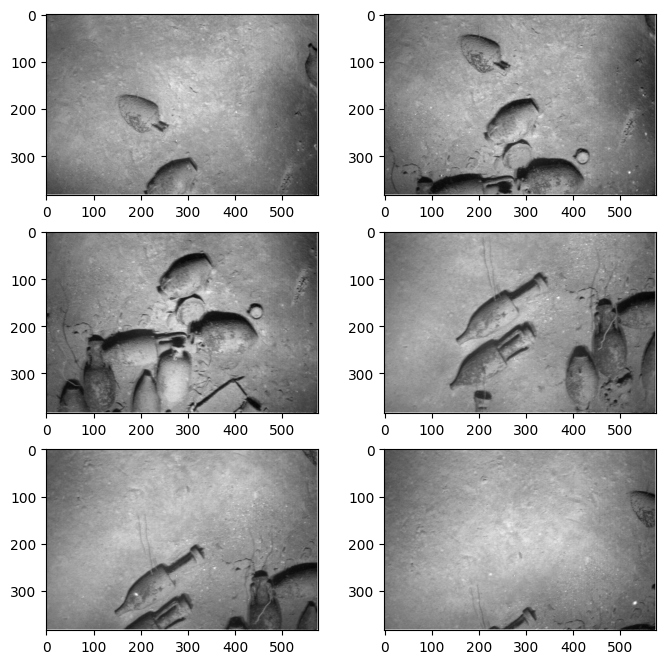

In [14]:
p1,p2,p3,p4,p5,p6 = read_images()
p123456=[*p1,*p2,*p3,*p4,*p5,*p6]

figure, ax = plt.subplots(3, 2, figsize=(8, 8))
pts=2000

ax[0,0].imshow(create_panorama(p1,num_matches=pts))
ax[0,1].imshow(create_panorama(p2,num_matches=pts))
ax[1,0].imshow(create_panorama(p3,num_matches=pts))
ax[1,1].imshow(create_panorama(p4,num_matches=pts))
ax[2,0].imshow(create_panorama(p5,num_matches=pts))
ax[2,1].imshow(create_panorama(p6,num_matches=pts))

STITCHED IMAGES

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(create_panorama(p123456,num_matches=pts))

PART 2

In [37]:
GraphContainer = namedtuple('GraphContainer', 'image keypoints')

def load_images_from_folder(folder_path, use_sift=True):

    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(".tif")]
    image_paths.sort()

    images_and_keypoints = []

    for path in image_paths:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (0, 0), fx=1, fy=1)

        keypoints = detect_and_compute_sift(image)

        images_and_keypoints.append(GraphContainer(image, keypoints))

    return images_and_keypoints

In [38]:
def find_noisy_matches(points1, points2, num_points=300):

    raw_matches, good_matches = match_points(points1.descriptors, points2.descriptors, num_points)

    if len(good_matches) < 6:
        return None, None

    homography = compute_homography_with_ransac(points1.keypoints, points2.keypoints, raw_matches, good_matches)

    diagonal_noise = 1000 * len(good_matches) ** -2 * np.array([1, 1, np.deg2rad(1)])

    gtsam_noise_model = gtsam.noiseModel.Diagonal.Sigmas(diagonal_noise)

    return homography, gtsam_noise_model

In [39]:
def convert_to_gtsam_pose(affine_matrix):

    x_translation = affine_matrix[0, -1]
    y_translation = affine_matrix[1, -1]
    rotation_angle = np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0])

    return gtsam.Pose2(x_translation, y_translation, rotation_angle)

In [40]:
def initialize_gtsam(imgs_and_pts: GraphContainer, initial_poses):

    cumulative_affine_matrix = np.eye(3)

    initial_poses.insert(0, gtsam.Pose2())

    for source_index in range(len(imgs_and_pts) - 1):
        target_index = source_index + 1

        affine_matrix, gtsam_noise = find_noisy_matches(imgs_and_pts[source_index].keypoints, imgs_and_pts[target_index].keypoints)

        cumulative_affine_matrix = affine_matrix @ cumulative_affine_matrix

        initial_poses.insert(target_index, convert_to_gtsam_pose(cumulative_affine_matrix))

    return cumulative_affine_matrix, initial_poses

In [88]:
def build_gtsam_graph(folder: str, use_sift: bool = True):

    imgs_and_pts = load_images_from_folder(folder, use_sift)

    prior_noise_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([10, 10, np.deg2rad(10)]))
    initial_poses = gtsam.Values()

    graph = gtsam.NonlinearFactorGraph()
    image_height, image_width = imgs_and_pts[0].image.shape[:2]

    camera_matrix = np.array([[1, 0, image_width / 2],
                               [0, 1, image_height / 2],
                               [0, 0, 1]])

    graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(image_width / 2, image_height / 2, 0), prior_noise_model))

    total_affine_matrix, initial_poses = initialize_gtsam(imgs_and_pts, initial_poses)

    for source_index, target_index in itertools.combinations(range(len(imgs_and_pts)), 2):
        if source_index + 1 == target_index:

            affine_matrix, gtsam_noise = find_noisy_matches(imgs_and_pts[source_index].keypoints, imgs_and_pts[target_index].keypoints)

            total_affine_matrix = affine_matrix @ total_affine_matrix

            graph.add(gtsam.BetweenFactorPose2(source_index, target_index,
                                                convert_to_gtsam_pose(affine_matrix), gtsam_noise))

        elif cv2.norm(initial_poses.atPose2(source_index).translation() - initial_poses.atPose2(target_index).translation()) < image_width * 0.8:

            affine_matrix, gtsam_noise = find_noisy_matches(imgs_and_pts[source_index].keypoints, imgs_and_pts[target_index].keypoints)

            if affine_matrix is None:
                break

            total_affine_matrix = affine_matrix @ total_affine_matrix

            graph.add(gtsam.BetweenFactorPose2(source_index, target_index,
                                                convert_to_gtsam_pose(affine_matrix), gtsam_noise))

    return graph, initial_poses, imgs_and_pts

In [84]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()])

    plt.show()

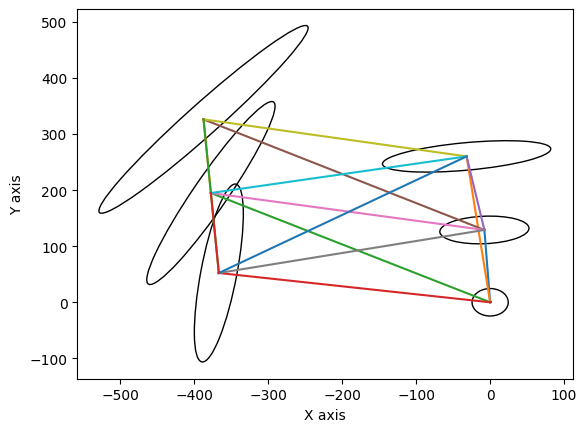

In [89]:
graph, initial, imgsAndPts = build_gtsam_graph("/content/drive/MyDrive/AFR Images/6Images")
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

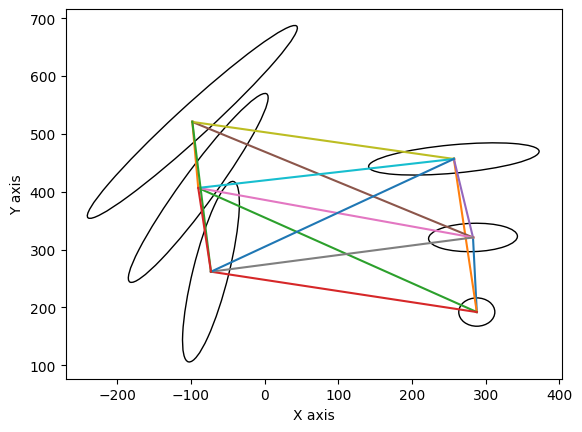

In [90]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

In [81]:
def gtimshow(imgsAndPts,graph, initial,blend=False,scale=1):
    Panorama = {"panopart":[]}
    poses = gtsam.utilities.allPose2s(initial)
    affine_matrix_list = []
    for index in range(len(imgsAndPts)):
        pose = poses.atPose2(index)
        affine_matrix = pose.matrix()
        affine_matrix_list.append(affine_matrix)
    for ind in range(len(imgsAndPts)):
        Panorama["panopart"].append({"img":imgsAndPts[ind].image,"H":affine_matrix_list[ind]})

    Panorama['canvas'],transH = find_dimensions(Panorama)
    for panopart in Panorama["panopart"]:
        panopart["H"] = np.matmul(transH,panopart["H"])
    warps = warp_images(Panorama)
    panoFinal=stitch_images(warps,Panorama["canvas"],blend,scale)
    return panoFinal

In [82]:
plt.figure(figsize=(8,8))
plt.imshow(gtimshow(imgsAndPts,graph,initial))

Covariance selection Justification:  Since, the covariance is being used as part of a function to plot graphs, specifically to visualize poses with an uncertainty measure provided by the covariance. The marginalCovariance(vertex_index) method is likely retrieving the covariance associated with a pose at a given vertex of each images.

Again this is possible because of the function used to plot the graph which is inspired from Jordan Gittleman


PART 3: 29 IMAGES

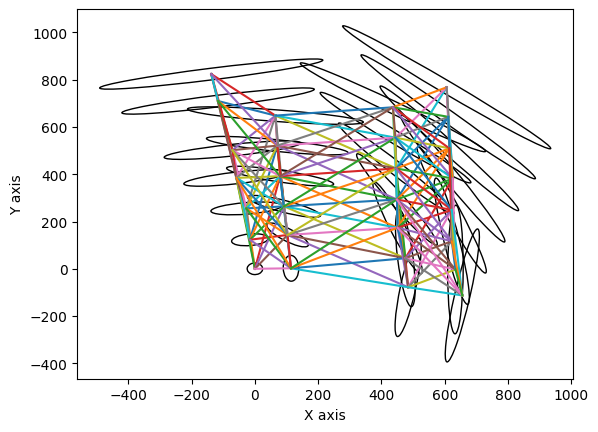

In [73]:
graph, initial, imgsAndPts = build_gtsam_graph("/content/drive/MyDrive/AFR Images/29images/29images_ALL/")
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

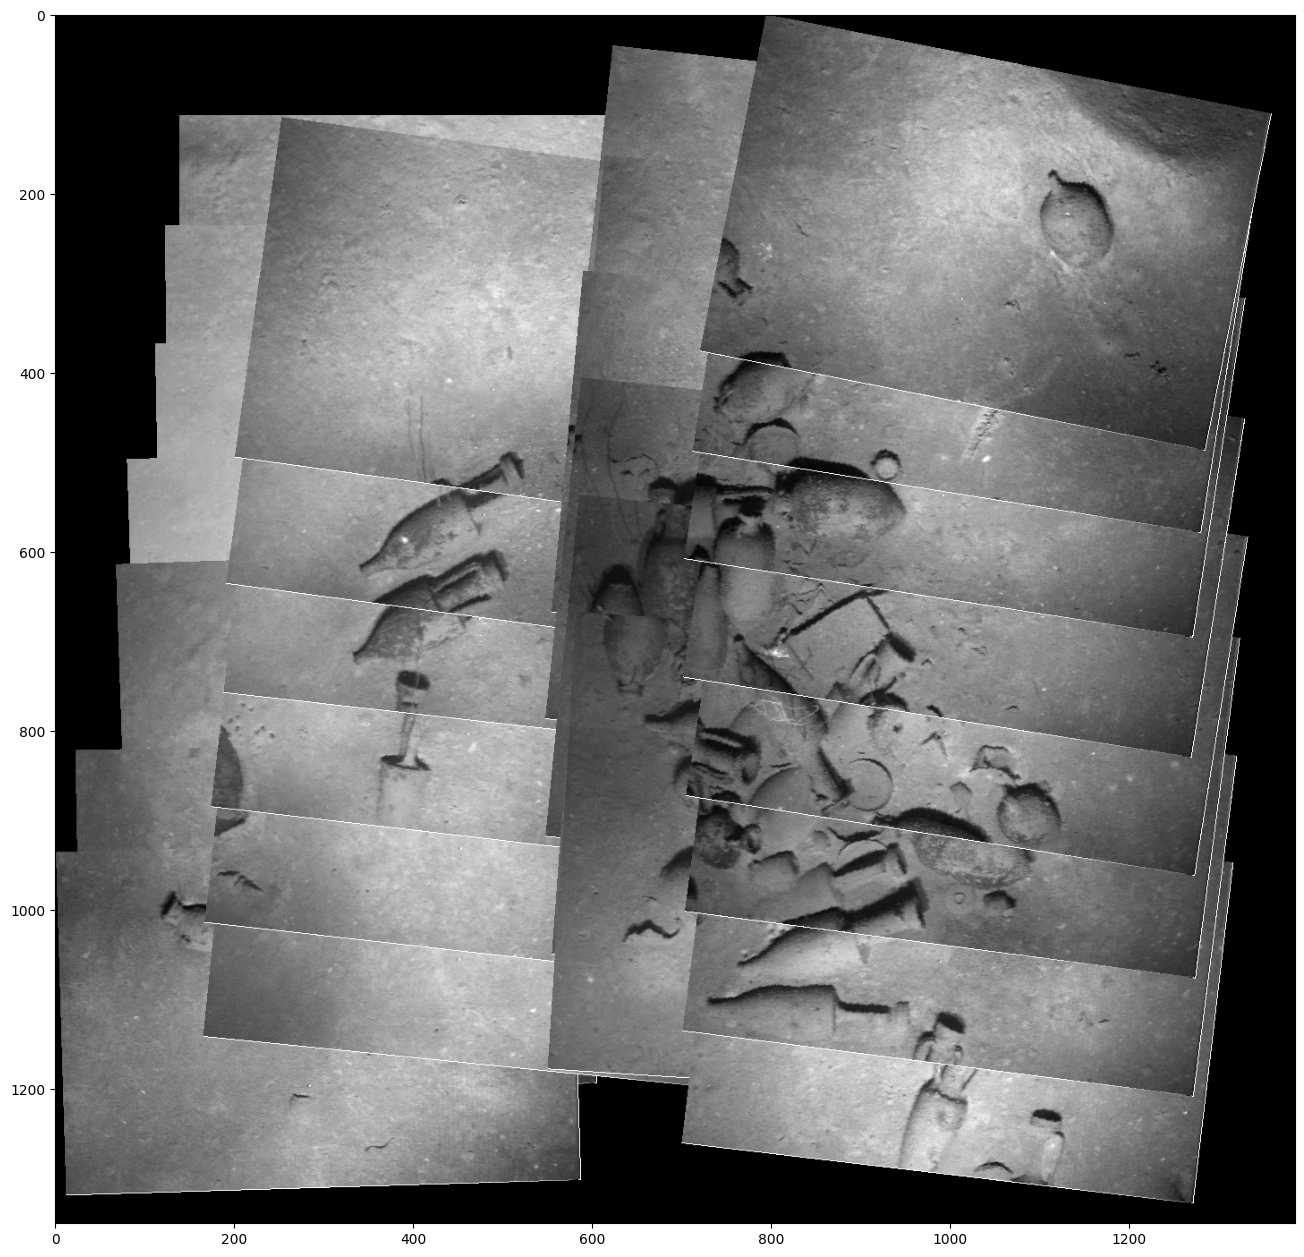

In [74]:
plt.figure(figsize=(16,16))
plt.imshow(gtimshow(imgsAndPts,graph,initial))

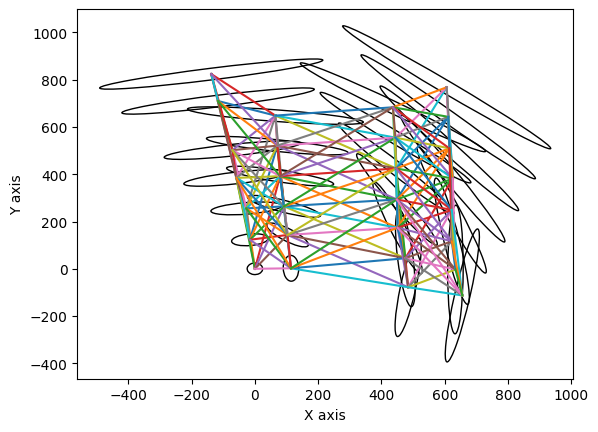

In [75]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

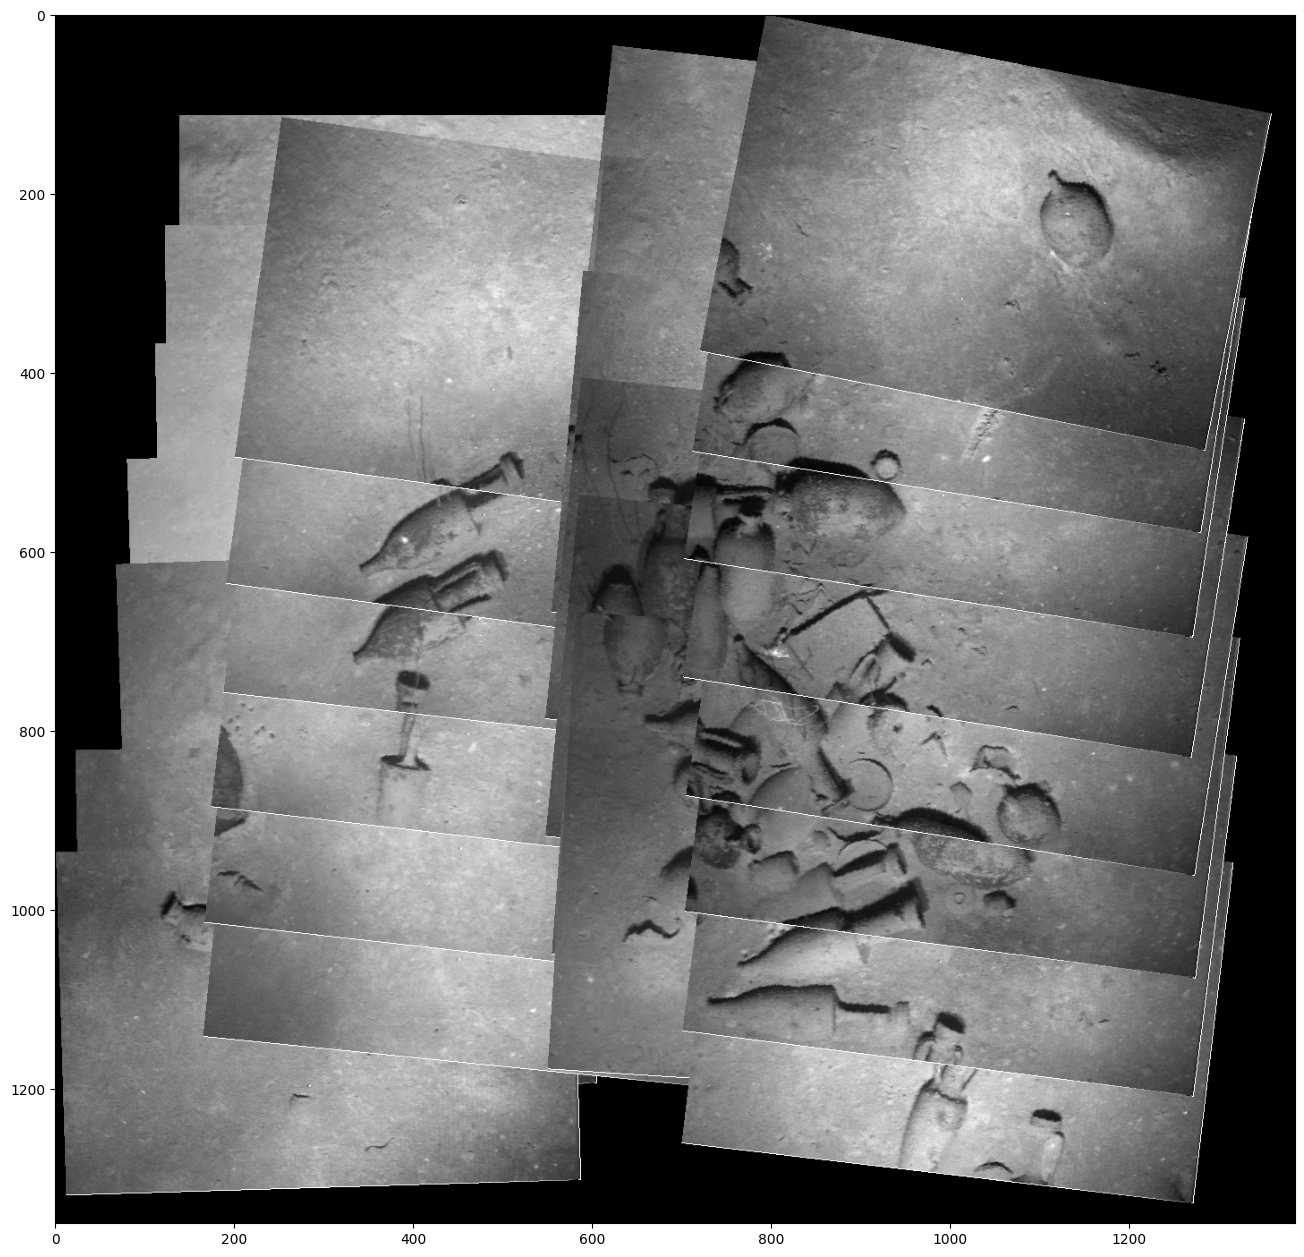

In [76]:
plt.figure(figsize=(16,16))
plt.imshow(gtimshow(imgsAndPts,graph,initial))

PART 4: FOR ENTIRE DATASET (tape018 file)

This part cannot be implemented it takes forever to run the entire dataset maybe its due to the huge dataset or my PC's limitations

In [72]:
graph, initial, imgsAndPts = build_gtsam_graph("/content/drive/MyDrive/AFR Images/252") #ignoring first 14 images from tape018 file
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

KeyboardInterrupt: 

In [56]:
plt.figure(figsize=(16,8))
plt.imshow(gtimshow(imgsAndPts,graph,initial,scale=0.4))

KeyboardInterrupt: 

<Figure size 1600x800 with 0 Axes>